# Kernel Mean Matching (KMM)

Kernel Mean Matching (KMM) assumes that training and test data are drawn from different distributions. KMM is a nonparametric method which directly produces resampling weights without distribution estimation, by matching distributions between training and testing sets in feature space. KMM accounts for difference between training and test distributions Pr⁡(x,y)and Pr'(x,y) by reweighting the training points such that the means of the training and test points in a reproducing kernel Hilbert space (RKHS) are close.
When Pr⁡and  Pr' differ only in Pr(x) ⁡and  Pr'(x), we have β(x,y)=  (Pr'(x))⁄(Pr⁡(x)), where β is a reweighting factor for the training examples. Thus, every observation (x,y)  reweighted such that observations that are under-represented in Pr obtain a higher weight, whereas over-represented cases are down weighted.


# Empirical KMM optimization

To find suitable values of β ∈ R^m, we want to minimize the discrepancy between means subject to constraints β_i  ∈[0,B]* and |1/m ∑_(i=1)^m β_{i-1}|≤ε. The former limits the scope of discrepancy between Pr⁡and  Pr' whereas the latter ensures that the measure β(x)Pr⁡(x) is close to a probability distribution. The objective function is given by the discrepancy term between the two empirical means. Using K_ij≔k(x_i,x_j) and k_i≔m/m^'  ∑_(j=1)^(m^')〖k(x_i,x_j^')〗 , we have:
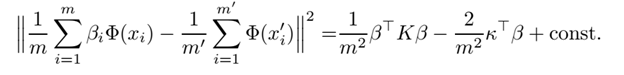

Then, to find suitable β, the quadratic problem is formulated as: 
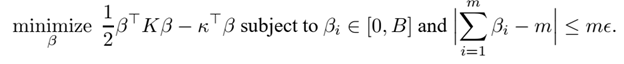

In [1]:
import numpy as np
import sklearn.metrics
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr 

In [2]:
#%% Kernel
def kernel(ker, X1, X2, gamma):
    K = None
    if ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1), np.asarray(X2))
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1))
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1), np.asarray(X2), gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1), None, gamma)
    return K

In [3]:
#%% Kernel Mean Matching (KMM)
class KMM:
    def __init__(self, kernel_type='linear', gamma=1.0, B=1.0, eps=None):
        '''
        Initialization function
        :param kernel_type: 'linear' | 'rbf'
        :param gamma: kernel bandwidth for rbf kernel
        :param B: bound for beta
        :param eps: bound for sigma_beta
        '''
        self.kernel_type = kernel_type
        self.gamma = gamma
        self.B = B
        self.eps = eps

    def fit(self, Xs, Xt):
        '''
        Fit source and target using KMM (compute the coefficients)
        :param Xs: ns * dim
        :param Xt: nt * dim
        :return: Coefficients (Pt / Ps) value vector (Beta in the paper)
        '''
        ns = Xs.shape[0]
        nt = Xt.shape[0]
        if self.eps == None:
            self.eps = self.B / np.sqrt(ns)
        K = kernel(self.kernel_type, Xs, None, self.gamma)
        kappa = np.sum(kernel(self.kernel_type, Xs, Xt, self.gamma) * float(ns) / float(nt), axis=1)

        K = matrix(K)
        kappa = matrix(kappa)
        G = matrix(np.r_[np.ones((1, ns)), -np.ones((1, ns)), np.eye(ns), -np.eye(ns)])
        h = matrix(np.r_[ns * (1 + self.eps), ns * (self.eps - 1), self.B * np.ones((ns,)), np.zeros((ns,))])

        sol = solvers.qp(K, -kappa, G, h)
        beta = np.array(sol['x'])
        return beta

In [4]:
# Reading the data
# X1 is in the source domain, and X2 is in the target domain

X1 = pd.read_csv("C:\\Users\\obazgir\\Dropbox\\TCGA-CCLE-TL\\CompareOtherTLAlgorithms\\MB_1_X1.csv")
X2 = pd.read_csv("C:\\Users\\obazgir\\Dropbox\\TCGA-CCLE-TL\\CompareOtherTLAlgorithms\\MB_1_X2.csv")
Y1 = pd.read_csv("C:\\Users\\obazgir\\Dropbox\\TCGA-CCLE-TL\\CompareOtherTLAlgorithms\\MB_1_Y1.csv")
Y2 = pd.read_csv("C:\\Users\\obazgir\\Dropbox\\TCGA-CCLE-TL\\CompareOtherTLAlgorithms\\MB_1_Y2.csv")
X1 = X1.values;  X2 = X2.values;   Y1 = Y1.values;   Y2 = Y2.values;

In [5]:
# X1 is the Tumor data , and X2 is the cell line data
#%% Kernel Mean Matching
kmm = KMM(kernel_type='rbf', B=1)
beta = kmm.fit(X1, X2)
X1_hat = beta*X1

     pcost       dcost       gap    pres   dres
 0:  9.5100e+02 -8.4207e+04  9e+04  1e-15  4e-10
 1:  9.5095e+02 -1.7015e+03  3e+03  7e-16  5e-12
 2:  9.0928e+02 -1.6625e+03  3e+03  2e-14  5e-12
 3:  9.0887e+02 -1.6423e+03  3e+03  1e-14  5e-12
 4:  9.0907e+02  4.9676e+02  4e+02  2e-14  2e-12
 5:  9.0900e+02  9.0460e+02  4e+00  3e-15  4e-14
 6:  9.0887e+02  9.0882e+02  4e-02  9e-15  7e-14
 7:  9.0887e+02  9.0886e+02  4e-04  1e-14  7e-14
Optimal solution found.


In [6]:
#%% Modeling
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state=0, n_estimators=200)
beta = beta.reshape(len(beta))
regr.fit(X2, Y2) 
Y1_hat = regr.predict(X1_hat)
Y1_hat = Y1_hat.reshape(len(Y1_hat),1)
#beta2 = kmm.fit(Y1, Y2)
#beta2 = beta2.reshape(len(beta2))
beta = beta.reshape(len(beta),1)
Y1_Pred = np.multiply(beta,Y1_hat)

C:\Users\obazgir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [8]:
#%% NRMSE
#Y1_Pred = Y1_hat
def NRMSE(Y_Target, Y_Predict):
    Y_Target = Y_Target.reshape(len(Y_Target),1);    Y_Predict = Y_Predict.reshape(len(Y_Predict),1);    
    Y_Bar = np.mean(Y_Target, axis = 0)
    Nom = np.sum((Y_Predict - Y_Target)**2);    Denom = np.sum((Y_Bar - Y_Target)**2)
    MSE = np.mean((Y_Predict - Y_Target)**2);   NRMSE = np.sqrt(Nom/Denom)
    return NRMSE, MSE


def NMAE(Y_Target, Y_Predict):
    Y_Target = Y_Target.reshape(len(Y_Target),1);    Y_Predict = Y_Predict.reshape(len(Y_Predict),1);  
    Nom = np.sum(np.abs(Y_Target - Y_Predict))
    Den = np.sum(np.abs(Y_Target - np.mean(Y_Target)))
    NMAE = Nom/Den
    return NMAE

NRMSE,MSE =  NRMSE(Y1, Y1_Pred)
SCC, SCC_Pval = spearmanr(Y1, Y1_Pred)
NMAE_Val = NMAE(Y1, Y1_Pred)

Results = np.array([NRMSE,NMAE_Val,SCC]);   Results = Results.reshape(1,len(Results))
Results_PD = pd.DataFrame(data = Results, columns = ['NRMSE','NMAE','SCC'])
print("NRMSE = ", NRMSE , ", NMAE = ", NMAE_Val, ", Spearman Correlation = ", SCC)

NRMSE =  1.0398803399741952 , NMAE =  1.0408204944561326 , Spearman Correlation =  -0.06090144731723068
